In [2]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import math
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Load the dataset
df = pd.read_csv('stocks_data.csv')
# Microsoft stock data
msft_data = df[df['symbol'] == 'MSFT'].copy()
# Converting date to datetime format
msft_data['date'] = pd.to_datetime(msft_data['date'])
msft_data.set_index('date', inplace=True)
msft_data.sort_index(inplace=True)
# close price for our analysis
close_prices = msft_data['close']

In [6]:
#Augmented Dickey-Fuller test
def check_stationarity(series):
    result = adfuller(series.dropna())
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    
    if result[1] <= 0.05:
        print("The series is stationary")
        return True
    else:
        print("The series is not stationary")
        return False

# Check if the original series is stationary
is_stationary = check_stationarity(close_prices)

ADF Statistic: -1.9103287622513443
p-value: 0.3272178447644152
The series is not stationary


In [8]:
# differencing if the series is not stationary
if not is_stationary:
    print("\nApplying first-order differencing")
    close_diff = close_prices.diff().dropna()
    
    # Check if the differenced series is stationary
    is_diff_stationary = check_stationarity(close_diff)
    
    # Use the differenced series if it's stationary
    if is_diff_stationary:
        series_to_model = close_diff
        d_value = 1
    else:
        # Apply second-order differencing if needed
        print("\nApplying second-order differencing")
        close_diff2 = close_diff.diff().dropna()
        check_stationarity(close_diff2)
        series_to_model = close_diff2
        d_value = 2
else:
    # Use the original series if it's already stationary
    series_to_model = close_prices
    d_value = 0


Applying first-order differencing
ADF Statistic: -16.681056100152066
p-value: 1.516264342713358e-29
The series is stationary


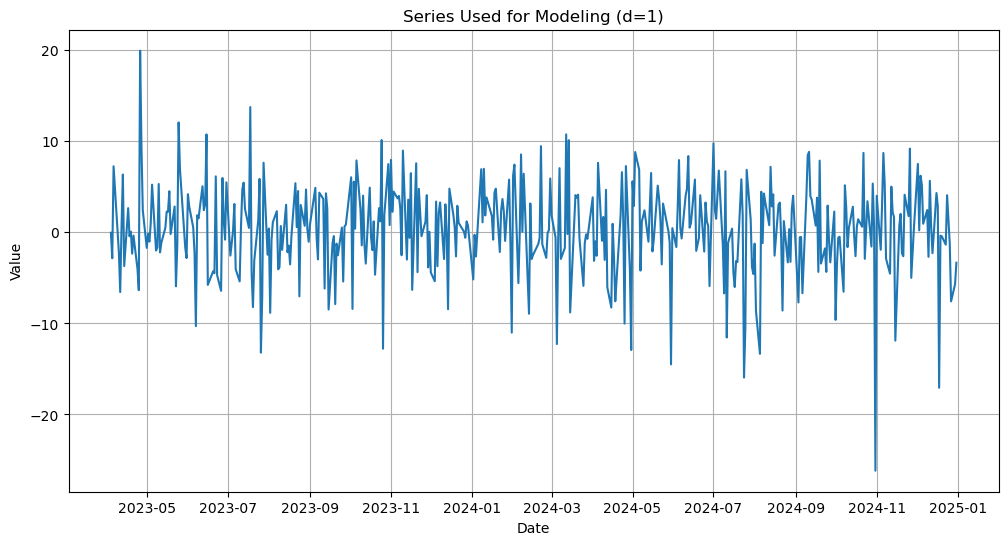

In [10]:
#this is the series we'll use for modeling
plt.figure(figsize=(12, 6))
plt.title(f'Series Used for Modeling (d={d_value})')
plt.plot(series_to_model)
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)
plt.show()

In [22]:
print("\nSplitting data into training and testing sets")

# Use 80% for training and 20% for testing
train_size = int(len(series_to_model) * 0.8)
train_data = series_to_model.iloc[:train_size]
test_data = series_to_model.iloc[train_size:]

print(f"Training data: {len(train_data)} observations")
print(f"Testing data: {len(test_data)} observations")


Splitting data into training and testing sets
Training data: 351 observations
Testing data: 88 observations


In [20]:
print("\n Building and training ARIMA model")
# Define p and q values 
p = 1  # AR order
q = 1  # MA order
d=0#since the data is already made stationary
# Create and fit ARIMA model
print(f"Training ARIMA({p}, {d_value}, {q}) model...")
model = ARIMA(train_data, order=(p, 0, q))  # d=0 because we've already differenced if needed
model_fit = model.fit()

print("\nModel summary:")
print(model_fit.summary().tables[0])
print(model_fit.summary().tables[1])


 Building and training ARIMA model
Training ARIMA(1, 1, 1) model...

Model summary:
                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  351
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1059.224
Date:                Tue, 06 May 2025   AIC                           2126.448
Time:                        16:51:19   BIC                           2141.891
Sample:                             0   HQIC                          2132.594
                                - 351                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3618      0.237      1.526      0.127      -0.103       0.827
ar.L1          0.3447      0.598      0.577   

In [18]:
print("\n Making predictions")
# Predict on test data
predictions = model_fit.forecast(steps=len(test_data))

# If we differenced the data, we need to invert the transformation
if d_value >= 1:
    # For first-order differencing
    original_predictions = [train_data.iloc[-1]]
    for pred in predictions:
        original_predictions.append(original_predictions[-1] + pred)
    original_predictions = original_predictions[1:]  # Remove the first element
    
    # Convert to the original scale from the test data
    original_test = [close_prices.iloc[train_size-1]]
    for diff in test_data:
        original_test.append(original_test[-1] + diff)
    original_test = original_test[1:]  # Remove the first element
    
    # Convert to numpy arrays for metrics calculation
    predictions_transformed = np.array(original_predictions)
    test_data_transformed = np.array(original_test)
else:
    # If we didn't difference, we can use the predictions directly
    predictions_transformed = predictions
    test_data_transformed = test_data.values


 Making predictions


In [27]:
print("\nEvaluating the model")
#error metrics
mse = mean_squared_error(test_data_transformed, predictions_transformed)
rmse = math.sqrt(mse)
mape = np.mean(np.abs((test_data_transformed - predictions_transformed) / test_data_transformed)) * 100

print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Mean Absolute Percentage Error: {mape:.2f}%")


Evaluating the model
Mean Squared Error: 172287.59
Root Mean Squared Error: 415.08
Mean Absolute Percentage Error: 96.91%



Visualizing results


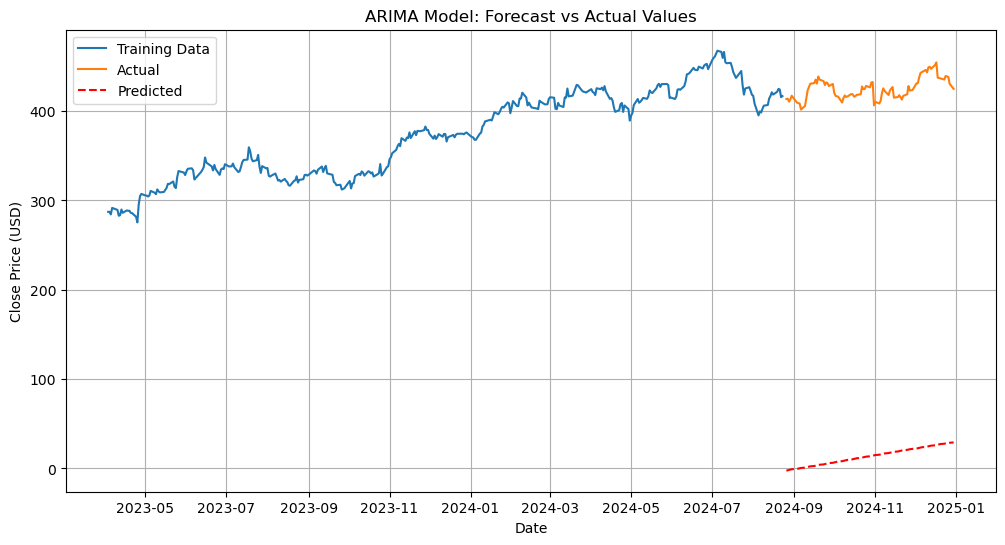

In [29]:
print("\nVisualizing results")
plt.figure(figsize=(12, 6))
plt.title('ARIMA Model: Forecast vs Actual Values')

if d_value >= 1:
    # original prices
    train_dates = close_prices.index[:train_size]
    test_dates = close_prices.index[train_size:train_size+len(test_data_transformed)]
    plt.plot(train_dates, close_prices.iloc[:train_size], label='Training Data')
    plt.plot(test_dates, close_prices.iloc[train_size:train_size+len(test_data_transformed)], label='Actual')
    plt.plot(test_dates, predictions_transformed, label='Predicted', color='red', linestyle='--')
else:
    # If no differencing was applied
    plt.plot(train_data.index, train_data, label='Training Data')
    plt.plot(test_data.index, test_data, label='Actual')
    plt.plot(test_data.index, predictions, label='Predicted', color='red', linestyle='--')

plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

In [31]:
print("\nForecasting future prices (next 20 days)")

# Generate future dates
last_date = close_prices.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=20, freq='B')

# Make future predictions
future_predictions = model_fit.forecast(steps=20)

#  we have differenced the data, so we need to invert the transformation
if d_value >= 1:
    # Initializing with the last known price
    future_prices = [close_prices.iloc[-1]]
    
    # Accumulate the differences
    for pred in future_predictions:
        future_prices.append(future_prices[-1] + pred)
    
    # Removing the first value (which was just the last known price)
    future_prices = future_prices[1:]
else:
    future_prices = future_predictions


Forecasting future prices (next 20 days)


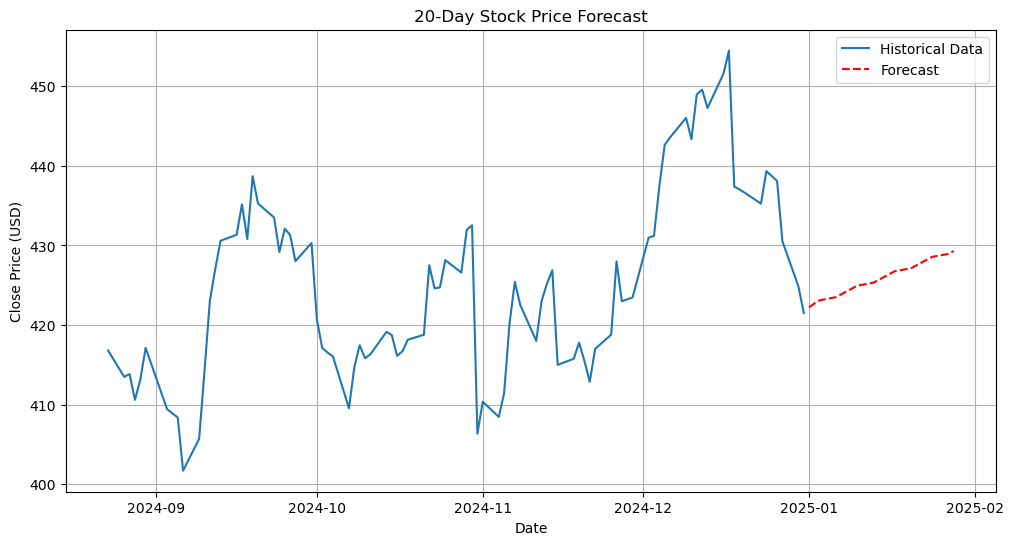

In [33]:
# Plot the forecast
plt.figure(figsize=(12, 6))
plt.title('20-Day Stock Price Forecast')
plt.plot(close_prices.index[-90:], close_prices.iloc[-90:], label='Historical Data')
plt.plot(future_dates, future_prices, label='Forecast', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

In [35]:
# DataFrame with the forecast
forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Forecasted_Price': future_prices
})

In [65]:
forecast_df

,Date,Forecasted_Price
0,2025-01-01,422.228782
1,2025-01-02,422.717102
2,2025-01-03,423.122524
3,2025-01-06,423.499367
4,2025-01-07,423.866357
5,2025-01-08,424.229950
6,2025-01-09,424.592373
7,2025-01-10,424.954392
8,2025-01-13,425.316271
9,2025-01-14,425.678103


In [51]:
jan_df = pd.read_csv('actual_jan.csv')
jan_msft = jan_df[jan_df['symbol'] == 'MSFT']
jan_close = jan_msft.reset_index()['close']
jandf = jan_close.values


In [53]:
jandf

array([418.58, 423.35, 427.85, 422.37, 424.56, 418.95, 417.19, 415.67,
       426.31, 424.58, 429.03, 428.5 , 446.2 , 446.71, 444.06, 434.56,
       447.2 , 442.33, 414.99, 415.06])

In [69]:
#DataFrame for actuals
actual_df = pd.DataFrame({
    'Date': pd.date_range(start='2025-01-01', periods=len(jandf), freq='B'),
    'Actual': jandf
})

# Merge on Date
merged_df = pd.merge(forecast_df, actual_df, on='Date')

# View merged result
print(merged_df)

         Date  Forecasted_Price  Actual
0  2025-01-01        422.228782  418.58
1  2025-01-02        422.717102  423.35
2  2025-01-03        423.122524  427.85
3  2025-01-06        423.499367  422.37
4  2025-01-07        423.866357  424.56
5  2025-01-08        424.229950  418.95
6  2025-01-09        424.592373  417.19
7  2025-01-10        424.954392  415.67
8  2025-01-13        425.316271  426.31
9  2025-01-14        425.678103  424.58
10 2025-01-15        426.039918  429.03
11 2025-01-16        426.401727  428.50
12 2025-01-17        426.763535  446.20
13 2025-01-20        427.125341  446.71
14 2025-01-21        427.487148  444.06
15 2025-01-22        427.848954  434.56
16 2025-01-23        428.210761  447.20
17 2025-01-24        428.572567  442.33
18 2025-01-27        428.934373  414.99
19 2025-01-28        429.296180  415.06


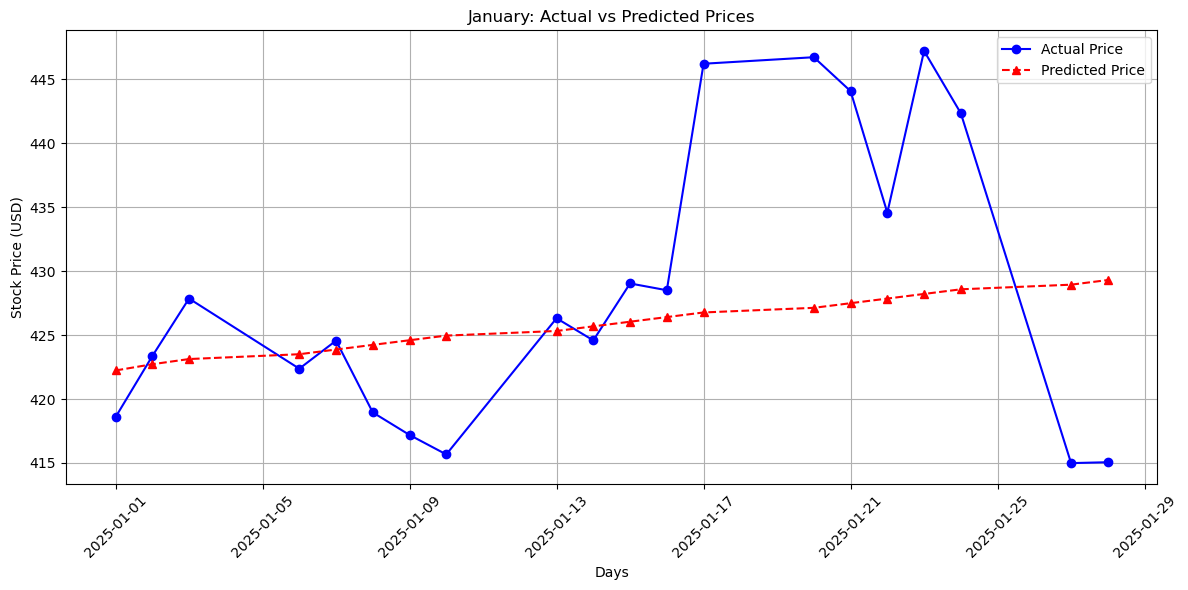

In [71]:
# Visualization of actual vs predicted January prices
plt.figure(figsize=(12, 6))
plt.title('January: Actual vs Predicted Prices')
plt.plot(merged_df['Date'], merged_df['Actual'], 'b-o', label='Actual Price')
plt.plot(merged_df['Date'], merged_df['Forecasted_Price'], 'r--^', label='Predicted Price')
plt.xlabel('Days')
plt.ylabel('Stock Price (USD)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [77]:
merged_df.to_csv('ARIMA_Results.csv')

In [75]:
#Sharpe Ratio
#daily returns from predicted prices
merged_df["Predicted_Return"] = merged_df["Forecasted_Price"].pct_change()

# considering 2% risk in investments
risk_free_rate = 0.02 / 252  # 252 trading days

#Excess returns
merged_df["Excess_Return"] = merged_df["Predicted_Return"] - risk_free_rate

#Sharpe Ratio
mean_excess_return = merged_df["Excess_Return"].mean()
std_excess_return = merged_df["Excess_Return"].std()
sharpe_ratio = mean_excess_return / std_excess_return

print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
#While technically a Sharpe Ratio of 10.82 suggests outstanding risk-adjusted return, in practice, it's a red flag to double-check your modeling and evaluation setup.

Sharpe Ratio: 10.8239
